# gene2csm.py

## Example usage

Use magic for inline plotting.

In [1]:
%matplotlib inline

Do the imports.

In [2]:
import gffutils
import os
import matplotlib.pyplot as plt
from Bio import SeqIO
import pandas as pd

# import gene2csm modules
from gene2csm import *
from gene2csm_out import prepare_output

---

### Create the required database objects

Create or load the GFF annotation database

In [3]:
db_file = 'danRer.GRCz10.90.db'
if not os.path.exists(db_file):
    db = gffutils.create_db("Danio_rerio.GRCz10.90.gtf",
                            dbfn="danRer.GRCz10.90.db",
                            id_spec={'gene': 'gene_id', 'transcript': "transcript_id"},
                            disable_infer_genes=True,
                            disable_infer_transcripts=True,
                            force=False)
else:
    db = gffutils.FeatureDB(db_file)

Create an indexed fasta database for faster access with SeqIO.

In [4]:
fa_db = SeqIO.index_db('danRer.GRCz10.dna_sm.toplevel.idx', 'Danio_rerio.GRCz10.dna_sm.toplevel.fa', 'fasta')

Load the variation information.

In [5]:
gvf_fn = ('danio_rerio.gvf.gz')

---

### Basic example of working with provided functions

Enter the Ensembl Gene ID

In [6]:
gene = db['ENSDARG00000008454']

Create genomic sequence coverage by **CDS** (without STOP codon).

In [7]:
gene_cov = get_cov(db, gene)

ENSDARG00000008454 loci length: 10529.
Maximal genomic sequence coverage by CDS: 3.


For plotting change start coordinates to local and reverse the coverage if needed

In [8]:
if gene.strand == '+':
    plot_cov = gene_cov
else:
    plot_cov = gene_cov[::-1]

Plotting

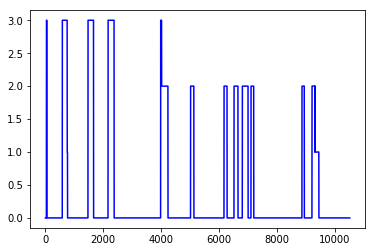

In [9]:
plt.plot(plot_cov, 'blue')
plt.show()

Get the genomic intervals for sequence retrieval. Subtract the variable sequences coming from dbSNP.

In [10]:
gen_int = sub_var(get_int(gene,gene_cov), gvf_fn)

17 CDS coverage intervals (coverage, count): [(2, 9), (3, 5), (1, 3)].
Subtracting variation from dbSNP_150.


---

### Automated design for multiple transcript targets

Define search parameters.

In [11]:
# length of the designed oligonucleotide
crRNA_len = 36
# limits of the %GC content
GC_limit = (40,60)
# number of processors to use
n_threads = 7

Provide the list of Ensembl Gene IDs to be used as design targets.

In [12]:
targets = ['ENSDARG00000014373',
           'ENSDARG00000035095']

Use the main function to conduct all the calculations. Raw output will also be stored in the CSV file. 


---

ddx4
ENSDARG00000014373 loci length: 21926.
Maximal genomic sequence coverage by CDS: 7.


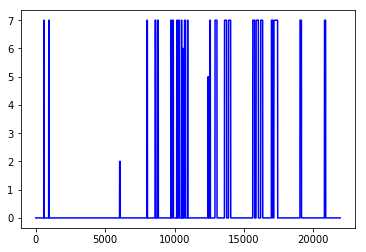

30 CDS coverage intervals (coverage, count): [(7, 23), (1, 2), (2, 1), (6, 1), (3, 1), (4, 1), (5, 1)].
Subtracting variation from dbSNP_150.
Processing 1638 nucleotides in 23 segments.
Valid sequences: 612 / 833 (GC_low = 156, GC_high = 51, sm = 14)
No transcript Ensemble ID specified.
Picking the longest, preferably HAVANA annotated transcript for free energy calculations.
Target: ENSDART00000149334, source: havana, length: 2856
612/612 (100.0%)
Writing file ENSDARG00000014373.result.csv.

Done.

---

tdgf1
ENSDARG00000035095 loci length: 6845.
Maximal genomic sequence coverage by CDS: 4.


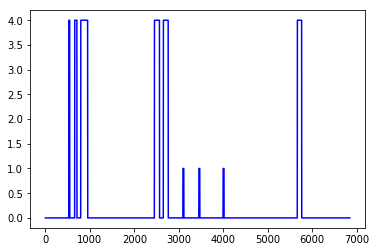

9 CDS coverage intervals (coverage, count): [(4, 6), (1, 3)].
Subtracting variation from dbSNP_150.
Processing 503 nucleotides in 6 segments.
Valid sequences: 183 / 293 (GC_low = 44, GC_high = 66, sm = 0)
No transcript Ensemble ID specified.
Picking the longest, preferably HAVANA annotated transcript for free energy calculations.
Target: ENSDART00000122446, source: ensembl, length: 2158
183/183 (100.0%)
Writing file ENSDARG00000035095.result.csv.

Done.


In [13]:
result = gene2csm(db, fa_db, gvf_fn, targets, crRNA_len, GC_limit, n_threads, coverage_limit='max')

Score the output, format the tables and write them to the XLSX files (if `write=True`). You can limit the number of outputted sequences to for example 50 by passing the `n_store=50` parameter.

In [14]:
formatted = prepare_output(result, n_store=0, write=False)

Analyze the output for each target. For convenience the result dictionary contains the Gene Names as keys.

In [15]:
formatted['ddx4'].head()

,seq,GC,ent,dG_AA,G_A,bitscore,nident,chr,start,end,score
190,UCUCACUGAACUUGCUGGCUGCCACACCAUCAGUCA,52.78,1.709314166666666666666666667,-12.28,-6.405086,30.1,16,10,6939268,6939304,103.4285714285714285714285714
189,CUCACUGAACUUGCUGGCUGCCACACCAUCAGUCAU,52.78,1.706084166666666666666666667,-12.19,-6.453289,30.1,16,10,6939267,6939303,105.4285714285714285714285714
188,UCACUGAACUUGCUGGCUGCCACACCAUCAGUCAUA,50.00,1.685921666666666666666666667,-12.19,-6.455337,30.1,16,10,6939266,6939302,110.4285714285714285714285714
187,CACUGAACUUGCUGGCUGCCACACCAUCAGUCAUAA,50.00,1.679088611111111111111111111,-12.17,-6.463978,30.1,16,10,6939265,6939301,115.4285714285714285714285714
211,UUAUGGCCUCAGGCUCCUGUAUCUCACUGAACUUGC,50.00,1.639284805555555555555555556,-8.29,-4.165267,30.1,16,10,6939289,6939325,121.4285714285714285714285714


---

### Working with user provided input

#### Sequence not part of an endogenous transcript

Input sequence should be provided in PLAIN or FASTA format. 

You can use lowercase letters to mask unwanted sequence regions.

In [16]:
egfp_seq = 'aggatccaccggtcgccaccatggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagtaaagcggccgc'

Use the `estimate_energy_input()` function for crRNA design, specifying the lenght of the designed oligos and the %GC content limits.

The user provided sequence will be used for free energy calculations.

Every designed oligonucleotide will be subject to a BLAST database search against all of the species RNA sequences.

In the example below we convert the whole sequence to uppercase as the argument for the function call:

In [17]:
plain_id, egfp_res = estimate_energy_input(egfp_seq.upper(), 36, (0,100), proc=7)

Valid sequences: 714 / 714 (GC_low = 0, GC_high = 0, sm = 0)
Using the provided sequence for free energy calculation.


Score and format the output. As input for `prepare_output()` function provide a list of tuples, containing sequence id and result from previous function call.

In [18]:
egfp_out = prepare_output([('eGFP', egfp_res)], n_store=0, write=False)

Analyze the output.

In [19]:
egfp_out['eGFP'].head()

,seq,GC,ent,dG_AA,G_A,bitscore,nident,chr,start,end,score
355,AUGCGGUUCACCAGGGUGUCGCCCUCGAACUUCACC,61.11,1.411554944444444444444444444,-10.52,-11.306073,28.3,18,.,355,391,166.8
170,CACGAGGGUGGGCCAGGGCACGGGCAGCUUGCCGGU,75.00,1.345367777777777777777777778,-9.36,-10.663815,28.3,18,.,170,206,188.8
169,ACGAGGGUGGGCCAGGGCACGGGCAGCUUGCCGGUG,75.00,1.3156325,-7.69,-10.650033,28.3,18,.,169,205,199.8
168,CGAGGGUGGGCCAGGGCACGGGCAGCUUGCCGGUGG,77.78,1.262398333333333333333333333,-7.76,-11.742355,28.3,17,.,168,204,224.8
649,AGCAGGACCAUGUGAUCGCGCUUCUCGUUGGGGUCU,58.33,1.261723222222222222222222222,-9.56,-7.146165,28.3,18,.,649,685,225.8


#### Sequence fragment of endogenous transcript

Input sequence should be provided in the FASTA format, containing parent **Ensembl Transcript ID** as the first element of the header (right after the '>' sign).

In [20]:
cpeb1b_2nd_exon_part = '>ENSDART00000098904 exon 2; partial sequence\nGCAGACGCCTTCTGCAGAATGAACACCATGCTGGGCAACTCACTGGATCTGAGTGGTGTGTGCACAACTCCCACTGCCAAGTGCAAGCGAGACCCTTTTA'

As in the example above use the `estimate_energy_input()` function to perform the calculations. This time provide also the **annotation database** and **fasta index** for the database lookup of the parent transcript sequence.

The whole parent transcript sequence will be used for free energy calculations.

The BLAST database search will exclude all of the transcript sequences of the parent gene.

In [21]:
c1_id, cpeb1b_part_res = estimate_energy_input(cpeb1b_2nd_exon_part, 36, (40,60), database=db, fasta_index=fa_db, proc=7)

Valid sequences: 64 / 65 (GC_low = 0, GC_high = 1, sm = 0)
Target: ENSDART00000098904, source: ensembl_havana, length: 2912


Score and format the output.

In [22]:
cpeb1b_part_out = prepare_output([('cpeb1b', cpeb1b_part_res)], n_store=0, write=False)

Analyze the output.

In [23]:
cpeb1b_part_out['cpeb1b'].head()

,seq,GC,ent,dG_AA,G_A,bitscore,nident,chr,start,end,score
20,CCACUCAGAUCCAGUGAGUUGCCCAGCAUGGUGUUC,55.56,2.557636111111111111111111111,-6.56,-6.513974,30.1,16,.,20,56,22.33333333333333333333333333
22,CACCACUCAGAUCCAGUGAGUUGCCCAGCAUGGUGU,55.56,2.551166666666666666666666667,-4.92,-8.147557,30.1,16,.,22,58,24.33333333333333333333333333
21,ACCACUCAGAUCCAGUGAGUUGCCCAGCAUGGUGUU,52.78,2.548902777777777777777777778,-6.27,-6.658569,30.1,16,.,21,57,25.33333333333333333333333333
19,CACUCAGAUCCAGUGAGUUGCCCAGCAUGGUGUUCA,52.78,2.534936111111111111111111111,-6.72,-6.496824,30.1,16,.,19,55,27.33333333333333333333333333
18,ACUCAGAUCCAGUGAGUUGCCCAGCAUGGUGUUCAU,50.00,2.496919444444444444444444444,-6.83,-6.120022,30.1,16,.,18,54,32.33333333333333333333333333


---

### Omitting certain *CDS containing exons* from processing

You can omit **CDS containing exons** from processing by passing the exon numbers as a dictionary in the `exclude_dict` argument to the `gene2csm` function, with Gene ID as the key. Example follows:

In [24]:
# list excluded exons in a dictionary
excluded_exons = {'ENSDARG00000014373': [1]}

# length of the designed oligonucleotide
crRNA_len = 36
# limits of the %GC content
GC_limit = (40,60)
# number of processors to use
n_threads = 7

I this example the first CDS containing exon will be excluded from the processing (`excluded_exons = {'ENSDARG00000014373': [1]}`). It is the second exon of this gene, since the first exon does not contain any coding sequence.

We add additional `file_prefx` argument to change the names of the files stored not to overwrite the previous results.


---

ddx4
ENSDARG00000014373 loci length: 21926.
Maximal genomic sequence coverage by CDS: 7.


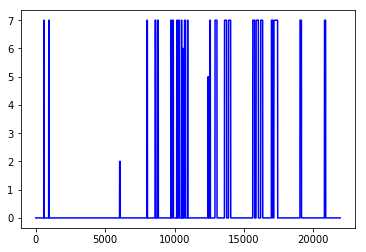

30 CDS coverage intervals (coverage, count): [(7, 23), (1, 2), (2, 1), (6, 1), (3, 1), (4, 1), (5, 1)].
Omitting user submitted *CDS containing exons*: 1..
Subtracting variation from dbSNP_150.
Processing 1638 nucleotides in 23 segments.
Valid sequences: 612 / 833 (GC_low = 156, GC_high = 51, sm = 14)
No transcript Ensemble ID specified.
Picking the longest, preferably HAVANA annotated transcript for free energy calculations.
Target: ENSDART00000149334, source: havana, length: 2856
612/612 (100.0%)
Writing file no1_ENSDARG00000014373.result.csv.

Done.


In [25]:
ddx4_res = gene2csm(db,
                    fa_db,
                    gvf_fn,
                    ['ENSDARG00000014373'],
                    crRNA_len,
                    GC_limit,
                    n_threads,
                    coverage_limit='max',
                    exclude_dict=excluded_exons,
                    file_prefix='no1_')

Score, format and analyze the output, as before.

In [26]:
ddx4_out = prepare_output(ddx4_res, n_store=50, write=True, file_prefix='no1_')

Writing file no1_ddx4.csm.xlsx.


In [27]:
ddx4_out['ddx4'].head()

,seq,GC,ent,dG_AA,G_A,bitscore,nident,chr,start,end,score
190,UCUCACUGAACUUGCUGGCUGCCACACCAUCAGUCA,52.78,1.709314166666666666666666667,-12.28,-6.405086,30.1,16,10,6939268,6939304,103.4285714285714285714285714
189,CUCACUGAACUUGCUGGCUGCCACACCAUCAGUCAU,52.78,1.706084166666666666666666667,-12.19,-6.453289,30.1,16,10,6939267,6939303,105.4285714285714285714285714
188,UCACUGAACUUGCUGGCUGCCACACCAUCAGUCAUA,50.00,1.685921666666666666666666667,-12.19,-6.455337,30.1,16,10,6939266,6939302,110.4285714285714285714285714
187,CACUGAACUUGCUGGCUGCCACACCAUCAGUCAUAA,50.00,1.679088611111111111111111111,-12.17,-6.463978,30.1,16,10,6939265,6939301,115.4285714285714285714285714
211,UUAUGGCCUCAGGCUCCUGUAUCUCACUGAACUUGC,50.00,1.639284805555555555555555556,-8.29,-4.165267,30.1,16,10,6939289,6939325,121.4285714285714285714285714


You can check, that because the first exon with the CDS of this gene is too short for crRNA design with those parameters, the resulting tables did not change:

In [28]:
ddx4_out['ddx4'].equals(formatted['ddx4'].head(50))

True

---

`System information:`

In [29]:
%%bash
bedtools --version
RNAfold --version
blastn -version
jupyter --version

bedtools v2.26.0
RNAfold 2.4.3
blastn: 2.7.1+
 Package: blast 2.7.1, build Oct 18 2017 19:57:24
4.4.0
